## imports

In [1]:
import os
import sys
from pathlib import Path
from pprint import pformat
from tempfile import TemporaryDirectory
from datetime import datetime, timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import geopandas as gpd
import pooch
import flopy
import flopy.plot
import flopy.utils
import rasterio
from rasterio.features import rasterize
from shapely.geometry import box
import contextily as cx
import re
from shapely.geometry import Point
from multiprocessing import Pool, cpu_count
import time
print(sys.version)
print(f"numpy version: {np.__version__}")
print(f"matplotlib version: {mpl.__version__}")
print(f"flopy version: {flopy.__version__}")

3.11.9 (main, Apr  2 2024, 13:43:44) [GCC 13.2.0]
numpy version: 1.26.3
matplotlib version: 3.9.2
flopy version: 3.9.2


## Read Simulation

In [4]:
# path to model directory
model_ws = './model'

# load MF6 simulation (this may take time)
sim = flopy.mf6.MFSimulation.load(sim_ws=model_ws, verbosity_level=1)

# get the GWF model
gwf = sim.get_model()

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package oc...
    loading package ic...
    loading package ghb...
    loading package npf...
    loading package sto...
    loading package hfb...
    loading package uzf...
  loading solution package rgtihm...


## Read Head and Budget

In [3]:
# manually define output file names (unlike mf2005)
head_file = os.path.join(model_ws, 'rgtihm.hds')
cbc_file = os.path.join(model_ws, 'rgtihm.cbc')

# read head file
headobj = flopy.utils.HeadFile(head_file)
head_times = headobj.get_times()
head = headobj.get_data(totim=head_times[-1])  # last timestep

# read cbc file
cbcobj = flopy.utils.CellBudgetFile(cbc_file, precision='double')
cbc_records = cbcobj.get_data(text='FLOW-JA-FACE', totim=head_times[-1])


NameError: name 'model_ws' is not defined

## Plots

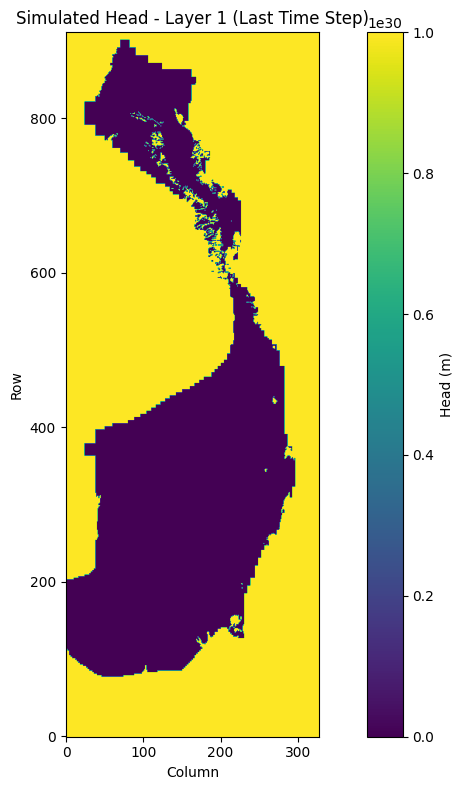

In [32]:
plt.figure(figsize=(10, 8))
plt.imshow(head[3], cmap='viridis', origin='lower')
plt.colorbar(label='Head (m)')
plt.title('Simulated Head - Layer 1 (Last Time Step)')
plt.xlabel('Column')
plt.ylabel('Row')
plt.tight_layout()
plt.show()


In [2]:
# editable list of (layer, row, col) tuples
cell_indices = [(3, 700, 150), (4, 650, 200), (4, 800, 100)]  # example cells

plt.figure(figsize=(10, 6))

for layer, row, col in cell_indices:
    ts = [headobj.get_data(totim=t)[layer, row, col] for t in head_times]
    plt.plot(head_times, ts, label=f'L{layer} R{row} C{col}')

plt.xlabel('Time')
plt.ylabel('Head (m)')
plt.title('Time Series of Head at Selected Cells')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'head_times' is not defined

<Figure size 1000x600 with 0 Axes>

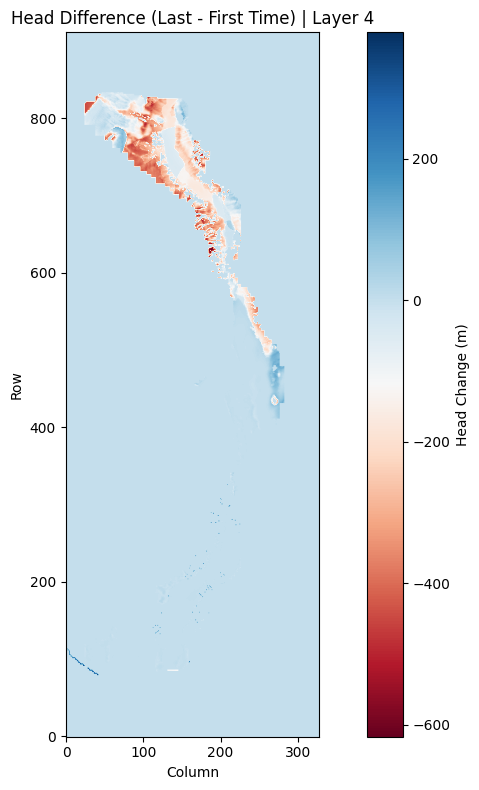

In [41]:
head_start = headobj.get_data(totim=head_times[3])
head_end = headobj.get_data(totim=head_times[-1])
head_diff = head_end[3] - head_start[3]

plt.figure(figsize=(10, 8))
plt.imshow(head_diff, cmap='RdBu', origin='lower')
plt.colorbar(label='Head Change (m)')
plt.title('Head Difference (Last - First Time) | Layer 4')
plt.xlabel('Column')
plt.ylabel('Row')
plt.tight_layout()
plt.show()


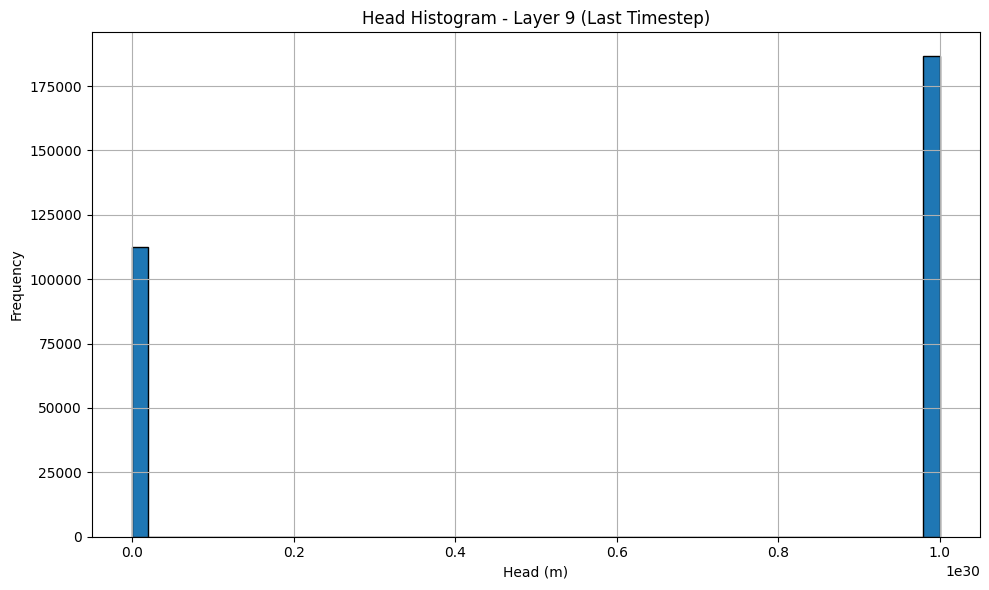

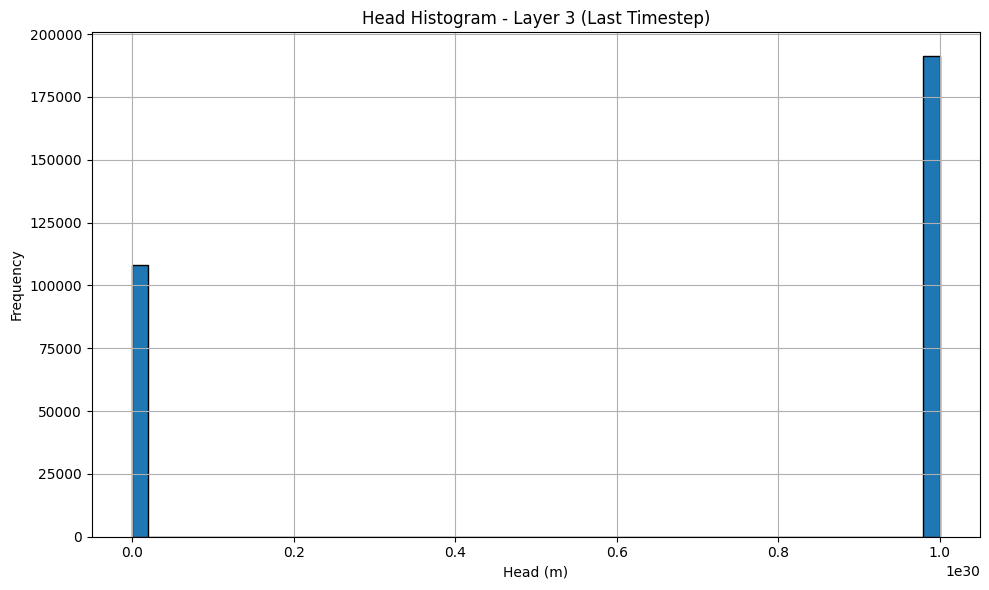

In [49]:
layer_id = 8  # change if needed
plt.figure(figsize=(10, 6))
plt.hist(head[layer_id].ravel(), bins=50, edgecolor='k')
plt.title(f'Head Histogram - Layer {layer_id+1} (Last Timestep)')
plt.xlabel('Head (m)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

layer_id = 2  # change if needed
plt.figure(figsize=(10, 6))
plt.hist(head[layer_id].ravel(), bins=50, edgecolor='k')
plt.title(f'Head Histogram - Layer {layer_id+1} (Last Timestep)')
plt.xlabel('Head (m)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()
